# Опционный калькулятор.

## Описание:

 - Выведем графики прибыли / убытка по опциону на дату погашения.
 - Применим формулу Блека - Шоулза для определения стоимости опциона.
 - Построим графики изменения значений премии и "греков" опциона в зависимости от разных факторов.

## Импорт библиотек:

In [1]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

## Определим пользовательские функции:

#### Функция расчета профиля p/l для фьючерса

In [3]:
def fut_pl(spot_prices, fut_init_price, fut_position):
  result = (spot_prices - fut_init_price)
  return result * fut_position

#### Функция расчета порфиля p/l опциона call

In [4]:
def call_pl(spot_prices, strike_call, call_premium, call_position):
  result = np.where((spot_prices < strike_call), (0-call_premium), (spot_prices - strike_call - call_premium))
  return result * call_position

#### Функция расчета профиля p/l опциона put

In [5]:
def put_pl(spot_prices, strike_put, put_premium, put_position):
  result = np.where((spot_prices < strike_put), (strike_put - spot_prices - put_premium), (0-put_premium))
  return result * put_position

#### Формула Блека - Шоулза (для опциона на фьючерс)

In [6]:
def d1_calc(spot, strike, sigma, T):
    result = (np.log(spot/strike) + 0.5 * (sigma ** 2) * (T)) / (sigma * np.sqrt(T))
    return result
def n_d1_calc(d1):
    result = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (d1 ** 2))
    return result
def premium(spot, strike, sigma, T, option_type):
    d1 = d1_calc(spot, strike, sigma, T)
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        N_d2 = norm.cdf(d2)
        delta_call = norm.cdf(d1)
        result = (spot * delta_call - strike * N_d2)
    if option_type == 'put':
        N_minus_d2 = norm.cdf(-d2)
        delta_put = (norm.cdf(d1) - 1)
        result = (strike * N_minus_d2 + spot * delta_put)
    return result
def delta(spot, strike, sigma, T, option_type):
    d1 = d1_calc(spot, strike, sigma, T)
    delta_call = norm.cdf(d1)
    if option_type == 'call':
        result = delta_call
    if option_type == 'put':
        result = (delta_call - 1)
    return result
def gamma(spot, strike, sigma, T):
    d1 = d1_calc(spot, strike, sigma, T)
    n_d1 = n_d1_calc(d1)
    result = n_d1 / (sigma * spot * np.sqrt(T))
    return result
def theta(spot, strike, sigma, T):
    d1 = d1_calc(spot, strike, sigma, T)
    n_d1 = n_d1_calc(d1)
    result = (-spot * n_d1 * sigma / (2 * np.sqrt(T))) / 365
    return result
def vega(spot, strike, sigma, T):
    d1 = d1_calc(spot, strike, sigma, T)
    n_d1 = n_d1_calc(d1)
    result = spot * np.sqrt(T) * n_d1 / 100
    return result

#### Класс для калькулятора

In [7]:
class option:
  def __init__(self, spot, strike, sigma, T, option_type):
    self.prem = premium(spot, strike, sigma, T, option_type)
    self.delta = delta(spot, strike, sigma, T, option_type)
    self.gamma = gamma(spot, strike, sigma, T)
    self.theta = theta(spot, strike, sigma, T)
    self.vega = vega(spot, strike, sigma, T)
    print('Премия опциона {}: {:.2f}'.format(option_type, self.prem))
    print('Дельта опциона {}: {:.2f}'.format(option_type, self.delta))
    print('Гамма опциона: {}'.format(self.gamma))
    print('1 / Гамма опциона: {:.2f}'.format(1/self.gamma))
    print('Тета опциона: {:.2f}'.format(self.theta))
    print('Вега опциона: {:.2f}'.format(self.vega))

## Расчет прибыли / убытка по опциону на дату погашения.

#### Зададим диапазон цен спот

In [8]:
spot_prices = np.arange(50000, 150000, 100)

#### Страйк опциона

In [9]:
strike = 100000

#### Размер уплаченной премии по опциону

In [10]:
option_premium = 4500

#### Размер позиции по опционам

In [11]:
size = 10

### Рассчитаем профиль P/L для опциона call

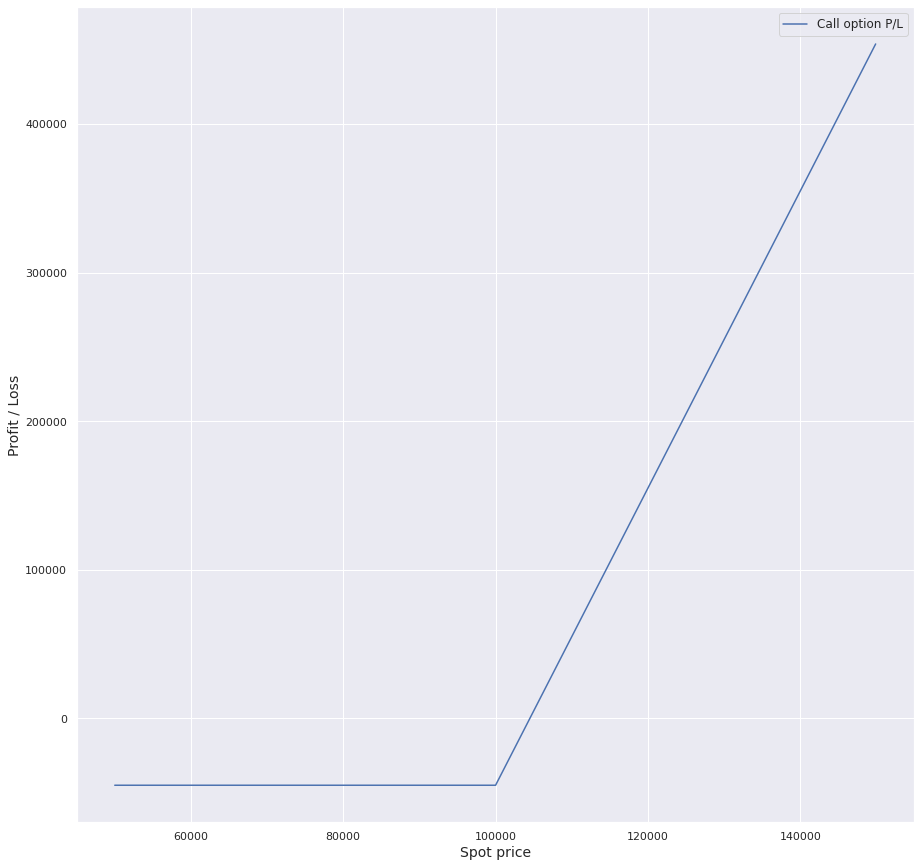

In [12]:
plt.figure(figsize=(15, 15))
plt.plot(spot_prices, call_pl(spot_prices, strike, option_premium, size), label = 'Call option P/L')
plt.xlabel('Spot price', fontsize=14)
plt.ylabel('Profit / Loss', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

### Рассчитаем профиль P/L для опциона put (при тех же условиях)

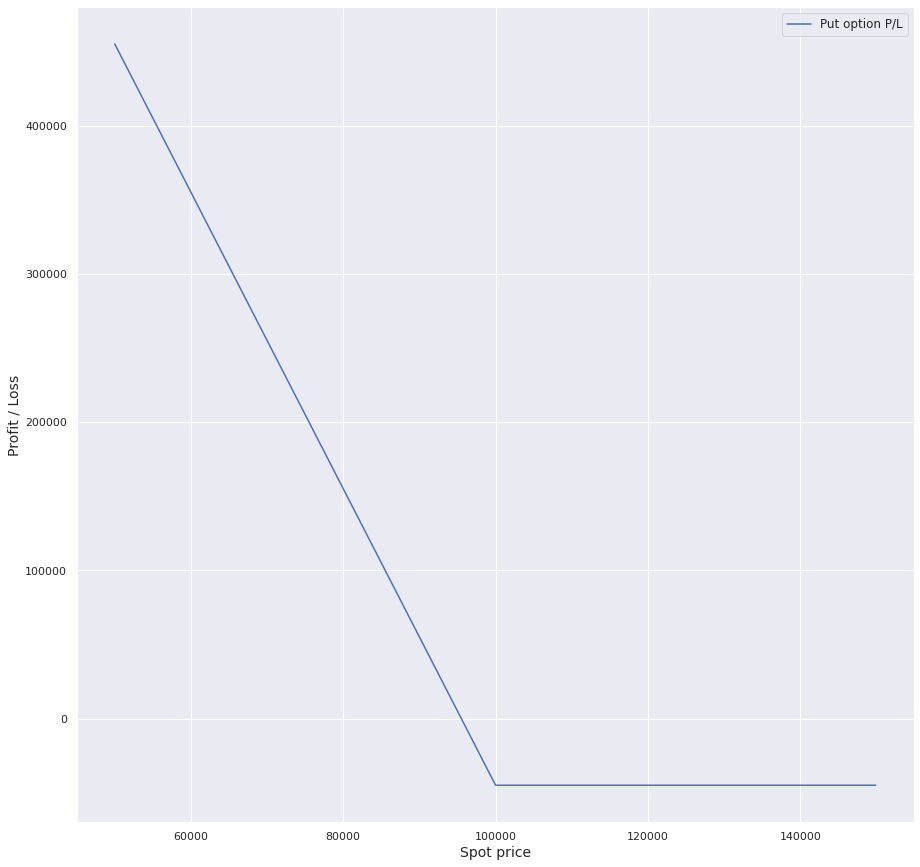

In [13]:
plt.figure(figsize=(15, 15))
plt.plot(spot_prices, put_pl(spot_prices, strike, option_premium, size), label = 'Put option P/L')
plt.xlabel('Spot price', fontsize=14)
plt.ylabel('Profit / Loss', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

### Построим график профиля P/L на дату погашения для портфеля фьючерсов и опционов.

#### Добавим составляющую по фьючерсам

In [14]:
fut_position = 0
fut_price = 100000

#### Добавим составляющую по опционам call

In [15]:
strike_call = 110000
call_premium = 2500
call_position = 100

#### Добавим составляющую по опционам put

In [16]:
strike_put = 90000
put_premium = 2500
put_position = 100

#### Построим график

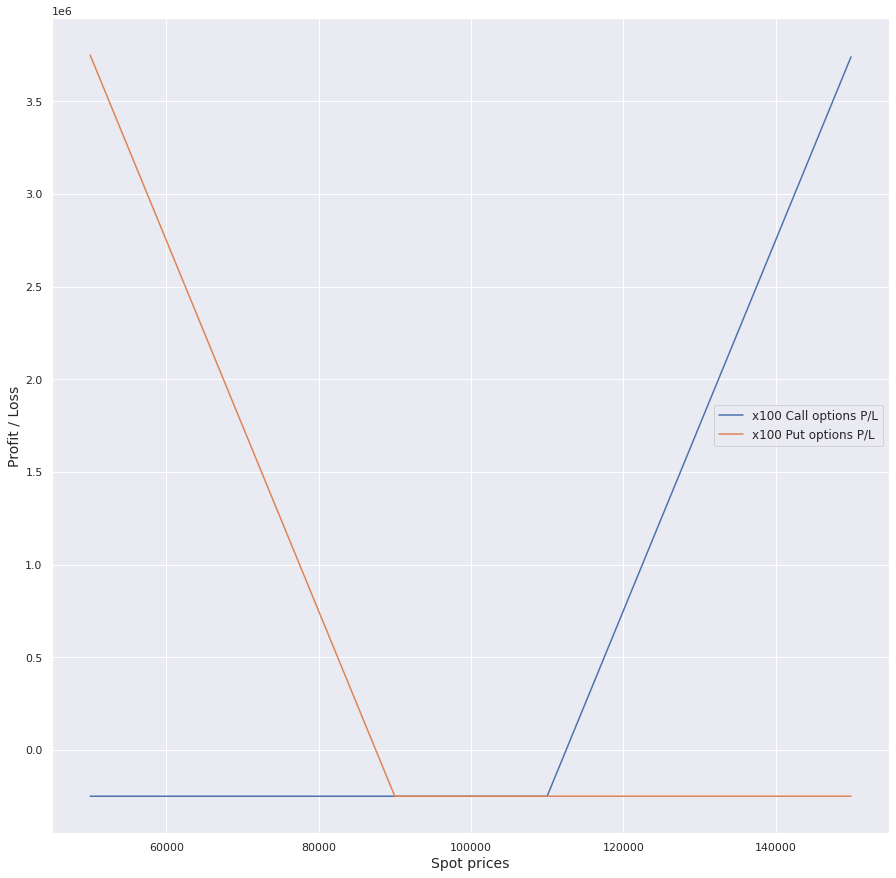

In [17]:
plt.figure(figsize = (15, 15))

if fut_position != 0:
    if fut_position == 1:
        fut_pos_lbl = 'x1 Future P/L'
    else:
        fut_pos_lbl = f'x{fut_position} Futures P/L'
    plt.plot(spot_prices, fut_pl(spot_prices, fut_price, fut_position), label = fut_pos_lbl)
    
if call_position != 0:
    if call_position == 1:
        call_pos_lbl = 'x1 Call option P/L'
    else:
        call_pos_lbl = f'x{call_position} Call options P/L'
    plt.plot(spot_prices, call_pl(spot_prices, strike_call, call_premium, call_position), label = call_pos_lbl)
    
if put_position != 0:
    if put_position == 1:
        put_pos_lbl = '1x Put option P/L'
    else:
        put_pos_lbl = f'x{put_position} Put options P/L'
    plt.plot(spot_prices, put_pl(spot_prices, strike_put, put_premium, put_position), label = put_pos_lbl)

plt.xlabel('Spot prices', fontsize=14)
plt.ylabel('Profit / Loss', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

## Перейдем непосредственно к калькулятору: рассчитаем премию опциона и его "греки" по формуле Блека - Шоулза

#### Обновим переменные, зададим текущую цену спот:

In [18]:
spot = 100000

#### страйк опциона:

In [19]:
strike = 100000

#### подразумеваемая волатильность

In [20]:
iv = 30

In [21]:
sigma = iv/100

#### число дней до экспирации (в календарных днях, число больше нуля)

In [22]:
t = 20

In [23]:
T = t/365

#### тип опциона ('call' или 'put')

In [24]:
option_type = 'call'

#### выведем значения

In [25]:
option(spot, strike, sigma, T, option_type)

Премия опциона call: 2800.98
Дельта опциона call: 0.51
Гамма опциона: 5.677439692676315e-05
1 / Гамма опциона: 17613.57
Тета опциона: -70.00
Вега опциона: 93.33


## Выведем графики изменения премии и "греков" опциона в зависимости от изменения различных факторов

### Графики зависимости свойств опциона от изменения цены спот

#### зададим диапазон цен спот

In [26]:
spot_prices = np.arange(85000, 115000, 100)

#### страйк опциона

In [27]:
strike = 100000

#### подразумеваемая волатильность

In [28]:
iv = 30

In [29]:
sigma = iv/100

#### число дней до экспирации (в календарных днях, число больше нуля)

In [30]:
t = 20

In [31]:
T = t/365

#### Размер позиции по опционам

In [32]:
size = 10

#### График изменения премии опциона

In [33]:
result_call = premium(spot_prices, strike, sigma, T, 'call')*size
result_put = premium(spot_prices, strike, sigma, T, 'put')*size

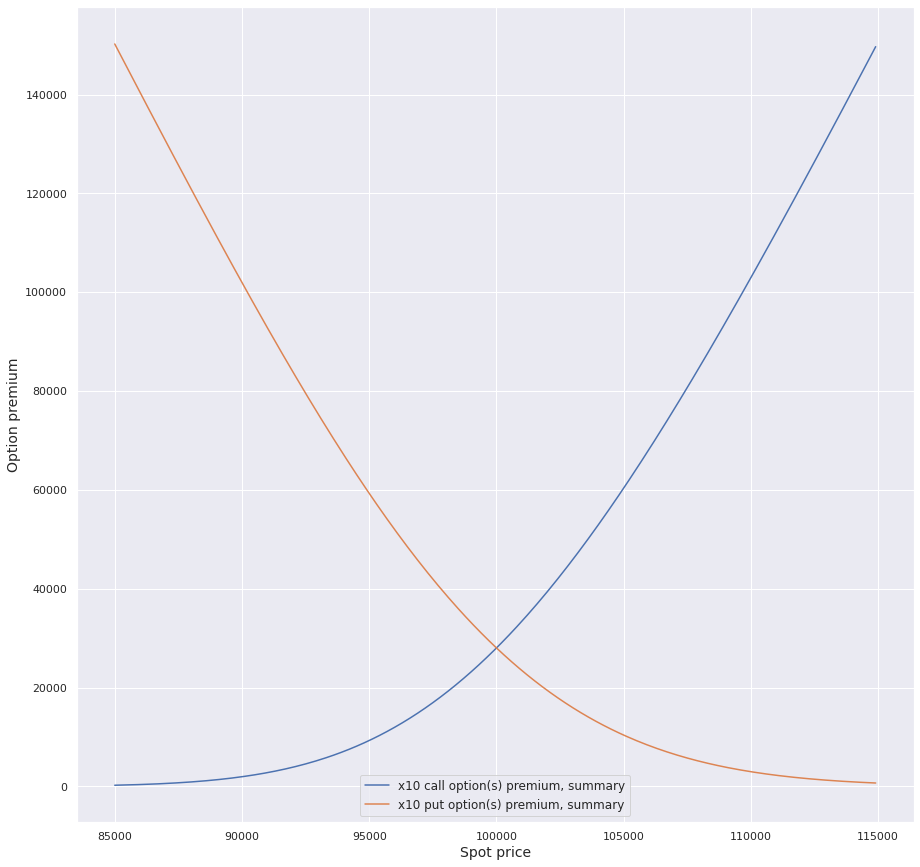

In [34]:
plt.figure(figsize=(15, 15))
plt.plot(spot_prices, result_call, label = 'x{} call option(s) premium, summary'.format(size))
plt.plot(spot_prices, result_put, label = 'x{} put option(s) premium, summary'.format(size))
plt.xlabel('Spot price', fontsize=14)
plt.ylabel('Option premium', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

#### График изменения дельты опциона

In [35]:
result_call = delta(spot_prices, strike, sigma, T, 'call')*size
result_put = delta(spot_prices, strike, sigma, T, 'put')*size

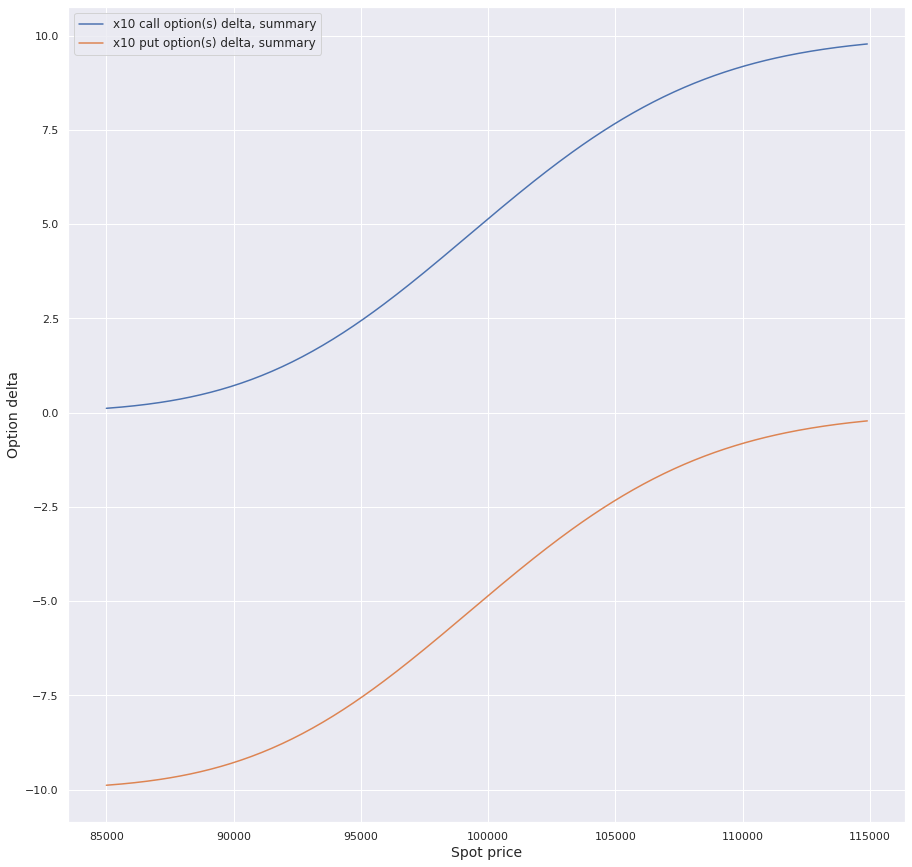

In [36]:
plt.figure(figsize=(15, 15))
plt.plot(spot_prices, result_call, label = 'x{} call option(s) delta, summary'.format(size))
plt.plot(spot_prices, result_put, label = 'x{} put option(s) delta, summary'.format(size))
plt.xlabel('Spot price', fontsize=14)
plt.ylabel('Option delta', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

#### График изменения гаммы опциона

In [37]:
result = gamma(spot_prices, strike, sigma, T)*size

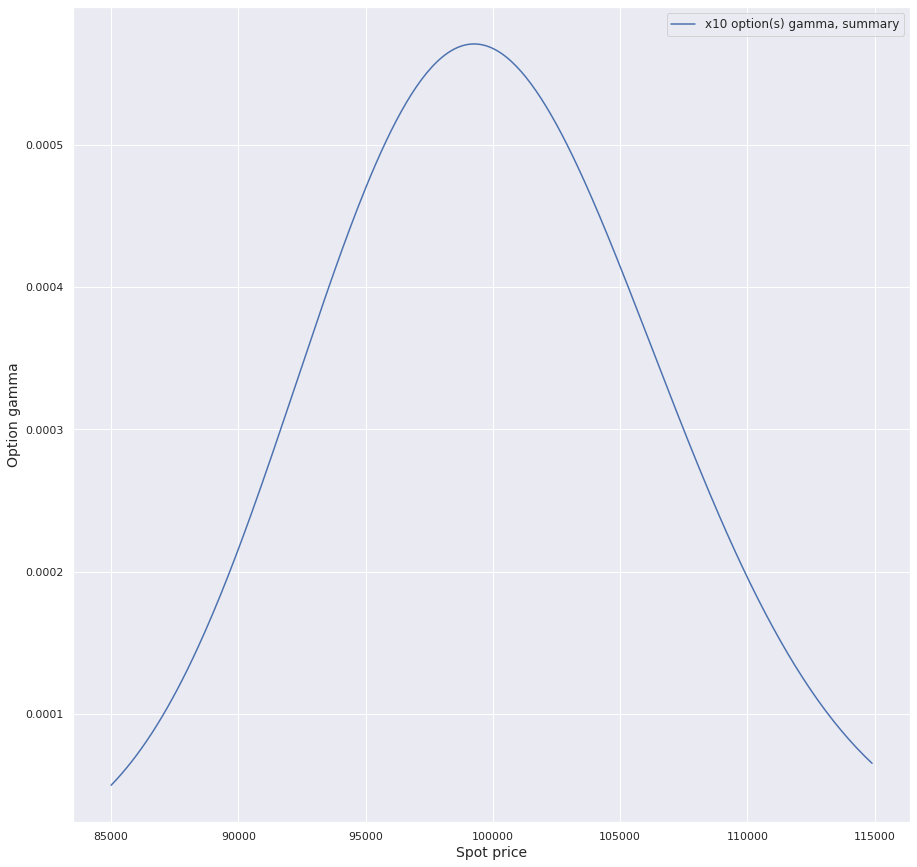

In [38]:
plt.figure(figsize=(15, 15))
plt.plot(spot_prices, result, label = 'x{} option(s) gamma, summary'.format(size))
plt.xlabel('Spot price', fontsize=14)
plt.ylabel('Option gamma', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

#### График изменения теты опциона

In [39]:
result = theta(spot_prices, strike, sigma, T)*size

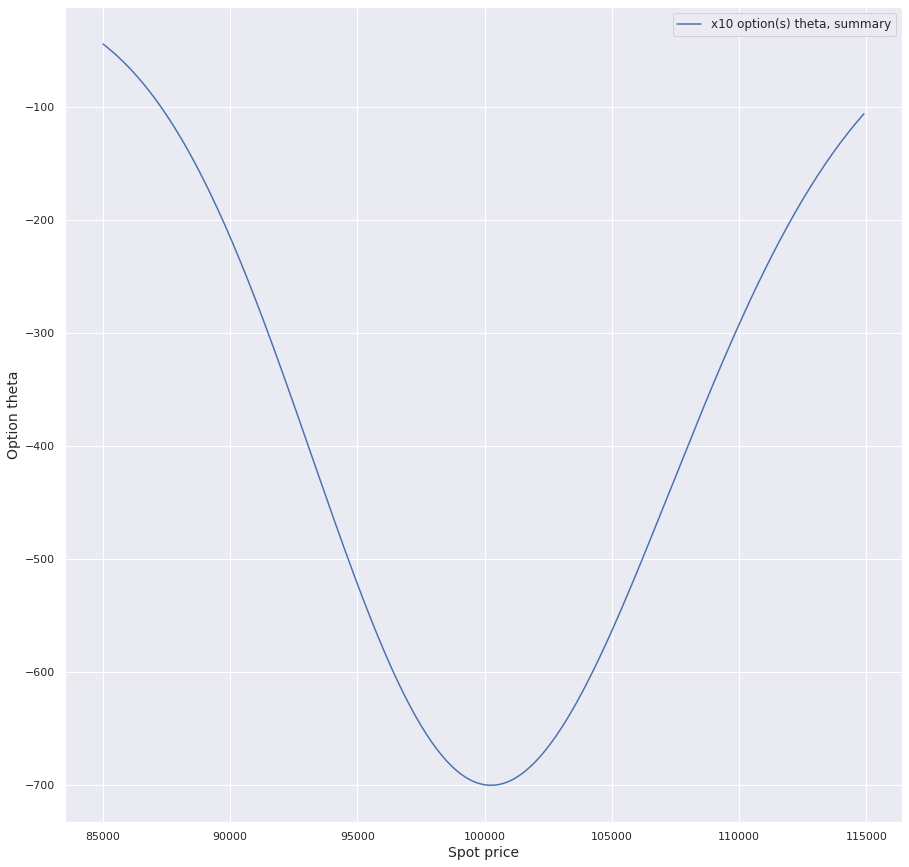

In [40]:
plt.figure(figsize=(15, 15))
plt.plot(spot_prices, result, label = 'x{} option(s) theta, summary'.format(size))
plt.xlabel('Spot price', fontsize=14)
plt.ylabel('Option theta', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

#### График изменения веги опциона

In [41]:
result = vega(spot_prices, strike, sigma, T)*size

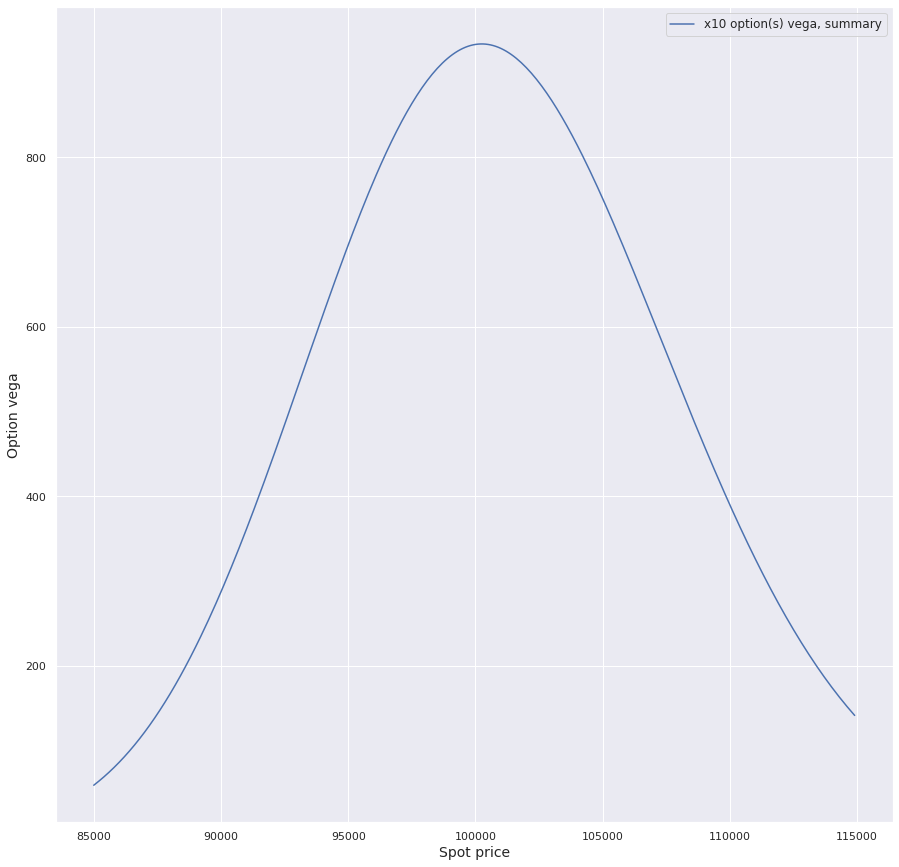

In [42]:
plt.figure(figsize=(15, 15))
plt.plot(spot_prices, result, label = 'x{} option(s) vega, summary'.format(size))
plt.xlabel('Spot price', fontsize=14)
plt.ylabel('Option vega', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

### Графики зависимости свойств опциона от изменения времени, оставшегося до экспирации опциона

#### зададим цену спот

In [43]:
spot = 100000

#### страйк опциона

In [44]:
strike = 100000

#### подразумеваемая волатильность

In [45]:
iv = 30

In [46]:
sigma = iv/100

#### число дней до экспирации (в календарных днях, число больше нуля)

In [47]:
t = np.arange(1, 91, 1)

In [48]:
T = t/365

#### Размер позиции по опционам

In [49]:
size = 1

#### График изменения премии опциона

In [50]:
result_call = premium(spot, strike, sigma, T, 'call')*size
result_put = premium(spot, strike, sigma, T, 'put')*size

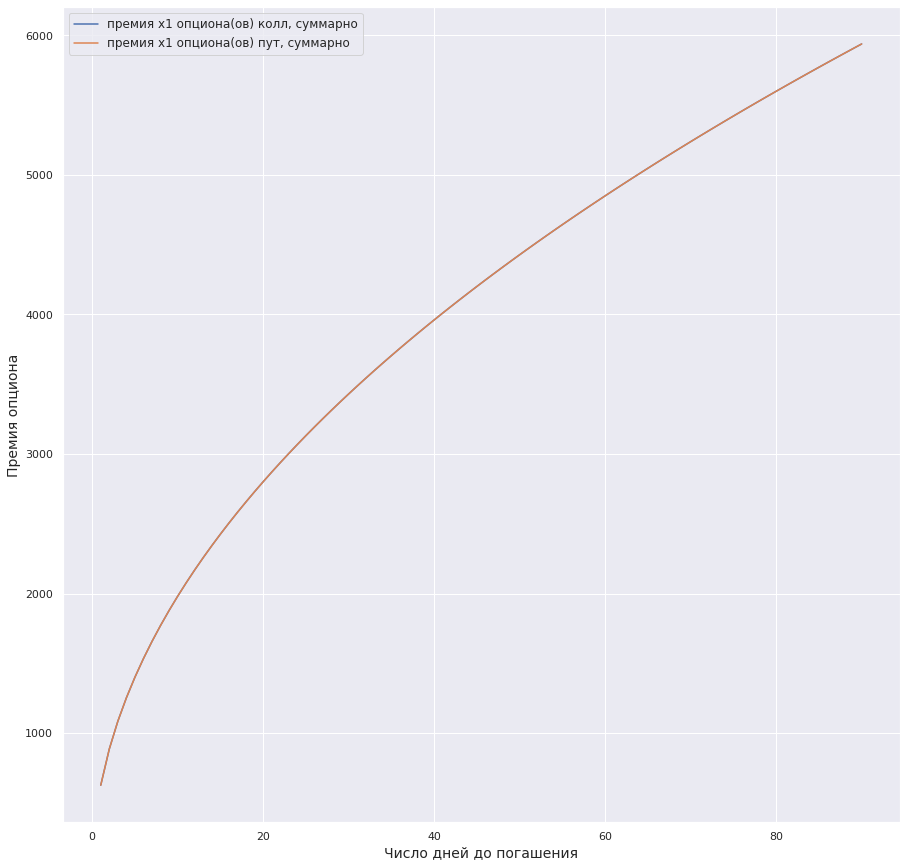

In [51]:
plt.figure(figsize=(15, 15))
plt.plot(t, result_call, label = 'премия x{} опциона(ов) колл, суммарно'.format(size))
plt.plot(t, result_put, label = 'премия x{} опциона(ов) пут, суммарно'.format(size))
plt.xlabel('Число дней до погашения', fontsize=14)
plt.ylabel('Премия опциона', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

#### График изменения теты опциона

In [52]:
result = theta(spot, strike, sigma, T)*size

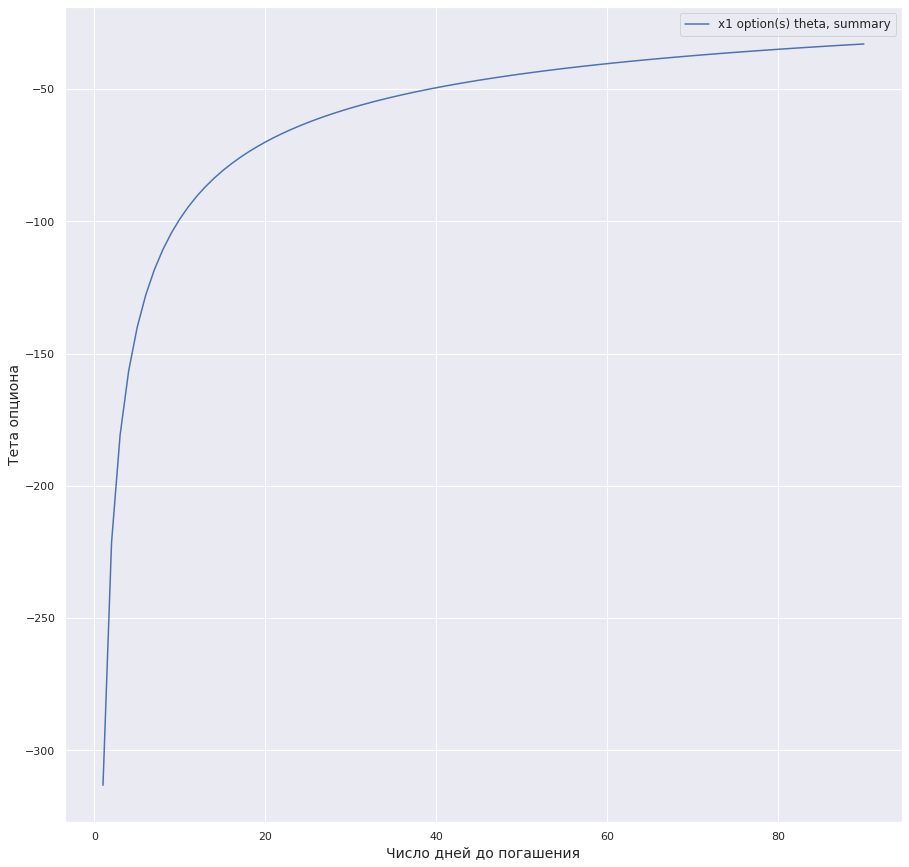

In [53]:
plt.figure(figsize=(15, 15))
plt.plot(t, result, label = 'x{} option(s) theta, summary'.format(size))
plt.xlabel('Число дней до погашения', fontsize=14)
plt.ylabel('Тета опциона', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

#### График изменения веги опциона

In [54]:
result = vega(spot, strike, sigma, T)*size

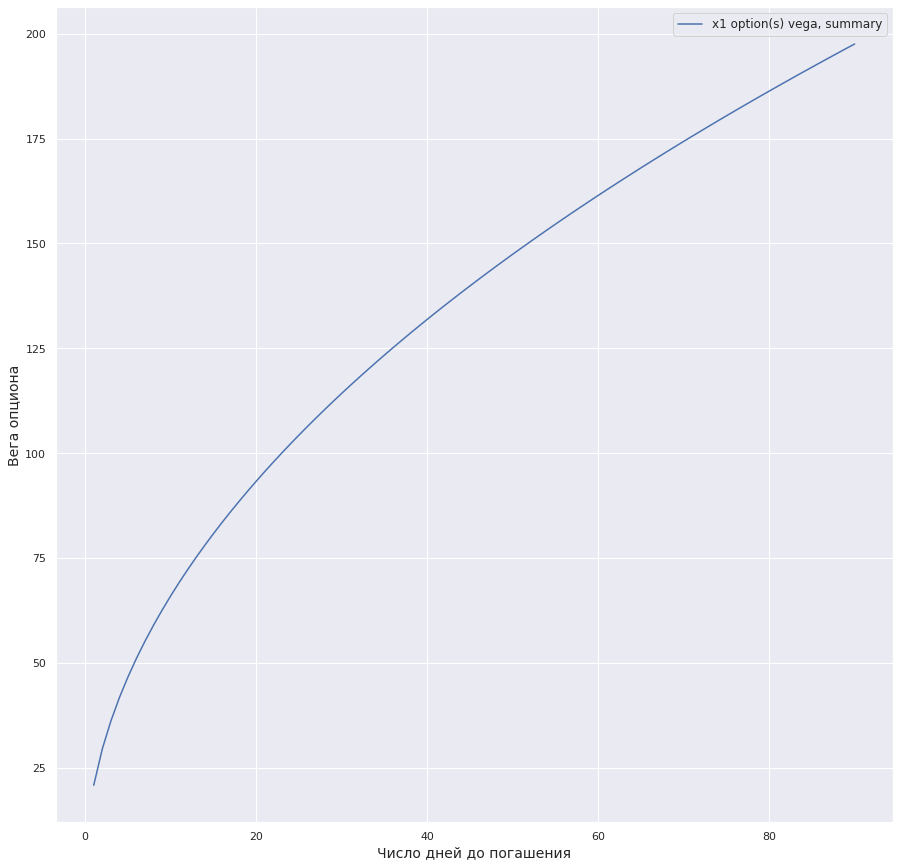

In [55]:
plt.figure(figsize=(15, 15))
plt.plot(t, result, label = 'x{} option(s) vega, summary'.format(size))
plt.xlabel('Число дней до погашения', fontsize=14)
plt.ylabel('Вега опциона', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

### Графики зависимости свойств опциона от изменения подразумеваемой волатильности

#### зададим цену спот

In [56]:
spot = 100000

#### страйк опциона

In [57]:
strike = 100000

#### подразумеваемая волатильность

In [58]:
iv = np.arange(10, 80, 1)

In [59]:
sigma = iv/100

#### число дней до экспирации (в календарных днях, число больше нуля)

In [60]:
t = 30

In [61]:
T = t/365

#### Размер позиции по опционам

In [62]:
size = 1

#### График изменения премии опциона

In [63]:
result_call = premium(spot, strike, sigma, T, 'call') * size
result_put = premium(spot, strike, sigma, T, 'put') * size

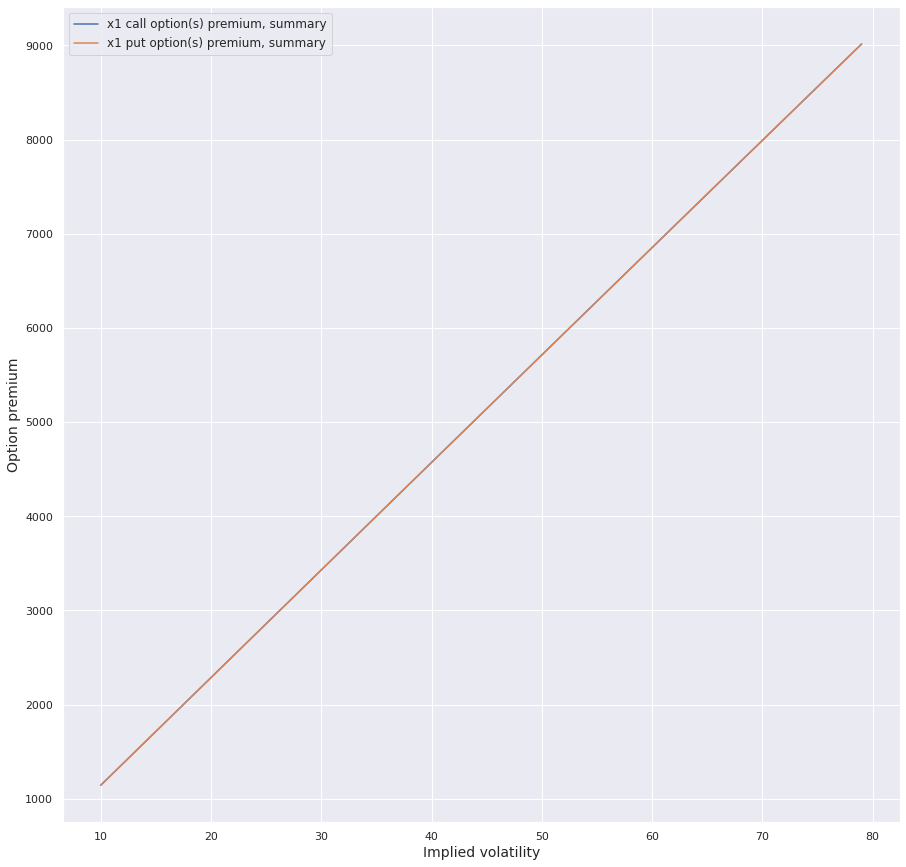

In [64]:
plt.figure(figsize=(15, 15))
plt.plot(iv, result_call, label = 'x{} call option(s) premium, summary'.format(size))
plt.plot(iv, result_put, label = 'x{} put option(s) premium, summary'.format(size))
plt.xlabel('Implied volatility', fontsize=14)
plt.ylabel('Option premium', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()

#### График изменения теты опциона

In [65]:
result = theta(spot, strike, sigma, T) * size

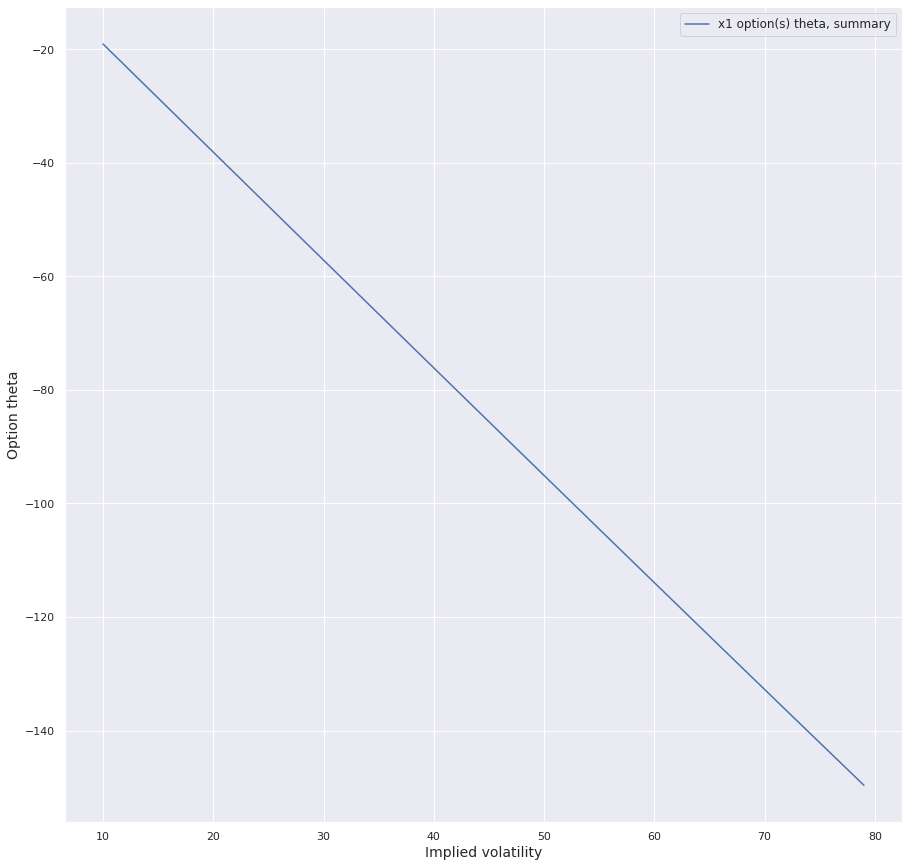

In [66]:
plt.figure(figsize=(15, 15))
plt.plot(iv, result, label = 'x{} option(s) theta, summary'.format(size))
plt.xlabel('Implied volatility', fontsize=14)
plt.ylabel('Option theta', fontsize=14)
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()